# Advanced Lane Line Detection

Employing camera distortion correction, color-space/gradient thresholding, and perspective transform, we detect the lane line on the road from the front-view perspective of video images captured from a front-facing camera mounted on a car.

In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import numpy as np

%matplotlib inline

------

In [2]:
def calibrate_camera(imgs, nx=9, ny=6):
    # Collect object points and image points for use in calibrating camera
    obj_pts = [] # 3D points in the real world space
    img_pts = [] # 2D points in the image plane
    sample_img = None
    
    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ... , (8,5,0)
    obj_pt = np.zeros((ny * nx, 3), np.float32)
    # z-coordinate will stay zero; but x, y coordinates need to be generated
    obj_pt[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    for fname in imgs:
        img = mpimg.imread(fname)
        
        if sample_img is None:
            sample_img = img

        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        found, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If corners are found, add object points and image points
        if found:            
            img_pts.append(corners)
            obj_pts.append(obj_pt)
            img = cv2.drawChessboardCorners(img, (nx,ny), corners, found)
            
    ret, cam_mtx, dist_coeffs, rot_vecs, trans_vecs = \
        cv2.calibrateCamera(obj_pts, img_pts, sample_img.shape[1::-1], None, None)
            
    return cam_mtx, dist_coeffs
        

In [3]:
def correct_distortion(image, cam_mtx, dist_coeffs):
    '''
    Calibrates camera and corrects for camera distortions in the provided image
    based on the provided camera matrix and distortion coefficients.
    Returns the corrected, undistorted image.
    
    arguments:
    cam_mtx -- camera matrix from camera calibration
    dist_coeffs -- distortion coefficients from camera calibratioSn
    '''
        
    return cv2.undistort(image, cam_mtx, dist_coeffs, None, None)

In [4]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    '''Calculate the directional gradient and apply the threshold'''
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobel = cv2.Sobel(gray, cv2.CV_64F, orient=='x', orient=='y', ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled = np.uint8((255 * abs_sobel) / np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled)
    grad_binary[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    return grad_binary


In [5]:
def mag_thresh(image, sobel_kernel=3, thresh=(0, 255)):
    '''Calculate the gradient magnitude and apply the threshold'''
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag_sobelxy = np.sqrt(np.square(sobelx) + np.square(sobely))
    scaled = np.uint8((255 * mag_sobelxy) / np.max(mag_sobelxy))
    mag_binary = np.zeros_like(scaled)
    mag_binary[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    return mag_binary


In [6]:
def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    '''Calculate gradient direction and apply the threshold'''
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag_sobelx = np.sqrt(np.square(sobelx))
    mag_sobely = np.sqrt(np.square(sobely))
    grad_dir = np.arctan2(mag_sobely, mag_sobelx)
    dir_binary = np.zeros_like(grad_dir)
    dir_binary[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    return dir_binary


In [7]:
def hls_threshold(image, channel='h', thresh=(90, 255)):
    '''Calculate the color threshold for the requested channel
    in the HLS (or HSL) color space and apply the threshold
    
    arguments:
    image -- a color image in RGB format
    channel -- the requested channel to use for applying the threshold values
    thresh -- min and max (inclusive) values for the range of the threshold to apply
    '''
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    layer = H
    if channel == 'l' or channel == 'L':
        layer = L
    elif channel == 's' or channel == 'S':
        layer = S
        
    hls_binary = np.zeros_like(layer)
    hls_binary[(layer > thresh[0]) & (layer <= thresh[1])] = 1
    return hls_binary


In [8]:
def rgb_threshold(image, channel='r', thresh=(90, 255)):
    '''Calculate the color threshold for the requested channel
    in the RGB color space and apply the threshold
    
    arguments:
    image -- a color image in RGB format
    channel -- the requested channel to use for applying the threshold values
    thresh -- min and max (inclusive) values for the range of the threshold to apply
    '''
    rgb = image
    
    R = rgb[:,:,0]
    G = rgb[:,:,1]
    B = rgb[:,:,2]
    
    layer = R
    if channel == 'g' or channel == 'G':
        layer = G
    elif channel == 'b' or channel == 'B':
        layer = B
        
    rgb_binary = np.zeros_like(layer)
    rgb_binary[(layer > thresh[0]) & (layer <= thresh[1])] = 1
    return rgb_binary


In [9]:
def lab_threshold(image, channel='l', thresh=(90, 180)):
    '''Calculate the color threshold for the requested channel
    in the LAB color space and apply the threshold
    
    arguments:
    image -- a color image in RGB format
    channel -- the requested channel to use for applying the threshold values
    thresh -- min and max (inclusive) values for the range of the threshold to apply
    '''
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    
    L = lab[:,:,0]
    A = lab[:,:,1]
    B = lab[:,:,2]
    
    layer = L
    if channel == 'a' or channel == 'A':
        layer = A
    elif channel == 'b' or channel == 'B':
        layer = B
        
    lab_binary = np.zeros_like(layer)
    lab_binary[(layer > thresh[0]) & (layer <= thresh[1])] = 1
    return lab_binary

In [10]:
def combine_thresholds(image, sobel_kernel_size=5, 
                       grad_x_thresh=(20, 100),
                       grad_y_thresh=(20, 100),
                       magnitude_thresh=(50, 75),
                       grad_dir_thresh=(0.65, 1.35),
                       s_chan_thresh=(180, 255),
                       h_chan_thresh=(70, 150),
                       l_chan_thresh=(150, 255),
                       L_chan_thresh=(150, 255),
                       A_chan_thresh=(100, 200),
                       B_chan_thresh=(100, 150),
                       r_chan_thresh=(150, 255),
                       g_chan_thresh=(100, 200),
                       b_chan_thresh=(80, 200)):
    '''
    Combines gradient and color thresholds applied to the provided image
    to maximize identification of lane lines
    '''
    # TODO: tune default threshold ranges
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) # just for visual reference
    
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=sobel_kernel_size, thresh=grad_x_thresh)
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=sobel_kernel_size, thresh=grad_y_thresh)
    mag_binary = mag_thresh(image, sobel_kernel=sobel_kernel_size, thresh=magnitude_thresh)
    dir_binary = dir_threshold(image, sobel_kernel=sobel_kernel_size, thresh=grad_dir_thresh)
    s_chan_binary = hls_threshold(image, channel='s', thresh=s_chan_thresh)
    h_chan_binary = hls_threshold(image, channel='h', thresh=h_chan_thresh)
    l_chan_binary = hls_threshold(image, channel='l', thresh=l_chan_thresh)
    L_chan_binary = lab_threshold(image, channel='L', thresh=L_chan_thresh)
    A_chan_binary = lab_threshold(image, channel='A', thresh=A_chan_thresh)
    B_chan_binary = lab_threshold(image, channel='B', thresh=B_chan_thresh)
    r_chan_binary = rgb_threshold(image, channel='r', thresh=r_chan_thresh)
    g_chan_binary = rgb_threshold(image, channel='g', thresh=g_chan_thresh)
    b_chan_binary = rgb_threshold(image, channel='b', thresh=b_chan_thresh)
    
    # Combine the selected applied thresholds 
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | \
             ((mag_binary == 1) & (dir_binary == 1)) | \
             ((s_chan_binary == 1) & (h_chan_binary == 0)) | \
             ((B_chan_binary == 0)) | \
             ((r_chan_binary == 1) & (b_chan_binary == 0))] = 1
    
    # TODO: consider eliminating returning all except the combined binary image. Currently, returning
    # all binaries solely for the purpose of give calling code access to binary images for displaying
    return combined, gray, gradx, grady, mag_binary, dir_binary, \
        s_chan_binary, h_chan_binary, l_chan_binary, \
        L_chan_binary, A_chan_binary, B_chan_binary, \
        r_chan_binary, g_chan_binary, b_chan_binary \
        


In [11]:
def warp_img(image, src, dst):
    '''
    Warps the provided image based on the provided src and dst points.
    '''
    perspective_M = cv2.getPerspectiveTransform(src, dst)
    img_size = (image.shape[1], image.shape[0])
    warped = cv2.warpPerspective(image, perspective_M, img_size, flags=cv2.INTER_LINEAR)
    perspective_Minv = cv2.getPerspectiveTransform(dst, src) # inverse matrix for reversing transforms
    
    return warped, perspective_M, perspective_Minv


In [12]:
def display_images(images, titles, cmaps=[]):
    '''
    Displays two images side by side.
    
    arguments:
    images -- a list of two images to display. (anything in the list beyond the first two will be ignored)
    cmaps  -- a list of color maps for the destination image
    titles -- a list of titles to match the provided images
    '''
    # TODO: play around with number of subplots rows and cols using len(images)
    #  to get a more dynamic grid than the current 1x2
    f, axs = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    for i in range(len(images)):
        if images[i] is not None:
            axs[i].set_title(titles[i], fontsize=30)
            if cmaps and cmaps[i] != '':
                axs[i].imshow(images[i], cmap=cmaps[i])
            else:
                axs[i].imshow(images[i])
              
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    

In [13]:
def draw_polygon(image, vertices, filename, color= 'r',):
    '''Draw polygon formed by the provide vertices onto the provided image'''
    fig, ax = plt.subplots(1)
    area_of_interest = patches.Polygon(vertices, fill=False, edgecolor=color)
    ax.imshow(image, cmap='gray')
    ax.add_patch(area_of_interest)
    plt.savefig('./output_images/'+filename)
    plt.show()

In [14]:
def get_histogram(image):
    '''Retrieve histogram of pixel density for lane lines in lower half of the image'''
    return np.sum(image[image.shape[0]//2:,:], axis=0)    
    

In [15]:
def eval_poly2_fit(polyfit2, d):
    '''
    ployfit2 -- the lane line 2-degree polynomial curve function fit to the lane line pixels
    d -- the dimension value to be evaluated in the polyfit function
    '''
    return polyfit2[0]*d**2 + polyfit2[1]*d + polyfit2[2]

In [16]:
def detect_lane_lines(warped_binary):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = get_histogram(warped_binary)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((warped_binary, warped_binary, warped_binary)) * 255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped_binary.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    sliding_windows = []
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped_binary.shape[0] - (window+1)*window_height
        win_y_high = warped_binary.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Save window corners for drawing the windows on the visualization image
        sliding_windows.append([(win_xleft_low,win_y_low),(win_xleft_high,win_y_high)])
        sliding_windows.append([(win_xright_low,win_y_low),(win_xright_high,win_y_high)])

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_binary.shape[0]-1, warped_binary.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fit, right_fit, leftx, lefty, rightx, righty, \
        sliding_windows, out_img, ploty, left_fitx, right_fitx


In [17]:
def visualize_detected_lanes(warped_binary, left_fit, right_fit, leftx, lefty,
                             rightx, righty, sliding_windows, out_img, ploty,
                             left_fitx, right_fitx):
    
    # NOTE: for some reason the cv2 api to draw a rectangle onto out_img did not work; but
    # the code was able to identify the lane pixels and calculate the polynomial fit curves.
    # Use matplotlib here to draw the sliding windows and lane pixels instead.
    fig, ax = plt.subplots(1)
    ax.imshow(out_img)

    #Draw lane line pixels
    ax.plot(leftx, lefty, color='red')
    ax.plot(rightx, righty, color='blue')

    #Draw sliding windows
    for win_corners in sliding_windows:
        l_x, b_y = win_corners[0]
        r_x, t_y = win_corners[1]
        vertices = [[l_x, b_y], [l_x, t_y], [r_x, t_y], [r_x, b_y]]
        win_box = patches.Polygon(vertices, fill=False, edgecolor='green')
        ax.add_patch(win_box)

    #Draw 2nd-degree polynomial fit curves
    ax.plot(left_fitx, ploty, color='yellow')
    ax.plot(right_fitx, ploty, color='yellow')

    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.savefig('./output_images/sliding-window-polyfit.png')
    plt.show()

    plt.xlim(0,1280)
    plt.plot(get_histogram(warped_binary))
    plt.savefig('./output_images/histogram.png')
    plt.show()
    

In [18]:
def calc_curvature(polyfit, d, conv_factor):
    '''
    Calculates the lane curvature in the real-world measurement
    
    arguments:
    ployfit -- the lane line 2-degree polynomial curve function fit to the lane line pixels
    d -- the dimension value to be evaluated in the polyfit function
    conv_factor -- the conversion factor from pixels to real-world measurement (e.g. meters/pixel)
    
    returns the radius of curvature in the real-world measurement based on the provided conversion factor
    '''
    return ((1 + (2*polyfit[0]*d*conv_factor + polyfit[1])**2)**1.5) / np.absolute(2*polyfit[0])

In [19]:
def lane_curvatures(left_x, left_y, right_x, right_y, y_eval):
    '''
    TODO: document this
    '''
    y_m_per_pixel = 30/720
    x_m_per_pixel = 3.7/700

    # Fit polynomials to real-world measurements
    left_fit_curve = np.polyfit(left_y*y_m_per_pixel, left_x*x_m_per_pixel, 2)
    right_fit_curve = np.polyfit(right_y*y_m_per_pixel, right_x*x_m_per_pixel, 2)

    # Calculate radii of curvature
    left_curve_rad = calc_curvature(left_fit_curve, y_eval, y_m_per_pixel)
    right_curve_rad = calc_curvature(right_fit_curve, y_eval, y_m_per_pixel)
    
    return left_curve_rad, right_curve_rad
    

In [20]:
def draw_lane(image, warped_img, corrected, persp_Minv, ploty, left_fitx, right_fitx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix
    newwarp = cv2.warpPerspective(color_warp, persp_Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(corrected, 1, newwarp, 0.3, 0)
    
    return result


In [21]:
def add_HUD_info(image, lane_curve_rads, vehicle_position):
    display = image
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontsize_mult = 1
    fontthickness = 2
    linetype = cv2.LINE_AA
    color_green = (0,255,0)
    color_white = (255,255,255)
    color_cyan = (87, 220, 217)
    
    # Add curvature data
    l_curvature = "{:>5.3f} km".format(lane_curve_rads[0]/1000)
    r_curvature = "{:>5.3f} km".format(lane_curve_rads[1]/1000)
    
    col1 = 50
    col2 = 125
    row_height = 40
    row1 = 100
    row2 = row1 + row_height
    row3 = row2 + row_height
    
    cv2.putText(display, 'Curvature Radius:', (col1, row1), font, fontsize_mult, color_cyan, fontthickness, linetype)
    cv2.putText(display, '  L', (col1, row2), font, fontsize_mult, color_cyan, fontthickness, linetype)
    cv2.putText(display, l_curvature, (col2, row2), font, fontsize_mult, color_cyan, fontthickness, linetype)
    cv2.putText(display, '  R', (col1, row3), font, fontsize_mult, color_cyan, fontthickness, linetype)
    cv2.putText(display, r_curvature, (col2, row3), font, fontsize_mult, color_cyan, fontthickness, linetype)
    
    # Add vehicle position data (offset from center of lane)
    middle = display.shape[1] // 2
    arrow_x = middle-70
    arrow = '<--'
    position = "{:>+5.2f} m".format(vehicle_position)
    
    if vehicle_position > 0:
        arrow = '-->'
        arrow_x = middle
        
    veh_pos_y = 600
    
    cv2.putText(display, position, (middle-70, veh_pos_y), font, fontsize_mult, color_white, fontthickness, linetype)
    cv2.putText(display, '|', (middle, veh_pos_y+row_height), font, fontsize_mult, color_white, fontthickness, linetype)
    cv2.putText(display, arrow, (arrow_x, veh_pos_y+row_height), font, fontsize_mult, color_white, fontthickness, linetype)
    
    return display


In [22]:
def position_offset(left_fitx, right_fitx, y_eval, image):
    '''Assume the camera is mounted at the center of the car,
    such that the lane center is the midpoint at the bottom of
    the image between the two lines detected. The offset of the
    lane center from the center of the image (converted from
    pixels to meters) is the distance from the center of the lane.
    '''
    x_m_per_pixel = 3.7/700
    left = eval_poly2_fit(left_fitx, y_eval)
    right = eval_poly2_fit(right_fitx, y_eval)
    lane_center = (left + right) / 2
    car_center = image.shape[1] / 2
    
    offset = car_center - lane_center
    
    return offset * x_m_per_pixel


In [23]:
def find_lane(image, cam_mtx, dist_coeffs, DEBUG=False):
    '''
    Finds driving lane within the provided image.
    arguments:
    cam_mtx -- camera matrix from camera calibration
    dist_coeffs -- distortion coefficients from camera calibration
    '''
    
    # Correct image distortions
    corrected = correct_distortion(image, cam_mtx, dist_coeffs)

    # Apply color and/or gradient thresholds
    combined_grad_color, gray, gradx, grady, mag_binary, \
    dir_binary, s_chan_binary, h_chan_binary, l_chan_binary, \
    L_chan_binary, A_chan_binary, B_chan_binary, \
    r_chan_binary, g_chan_binary, b_chan_binary = \
        combine_thresholds(corrected)

    # Apply perspective transform
    # Source image vertices for area of interest
    # TODO: update to have dynamic values based on image size
    stlx =  585
    strx =  700
    st_y =  455
    sblx =  200
    sbrx = 1110
    sb_y =  720

    src = np.float32([[strx, st_y],[sbrx, sb_y],
                      [sblx, sb_y],[stlx, st_y]])

    # Destination image vertices for transformed area of interest
    # TODO: update to have dynamic values based on image size
    dtlx =  320
    dtrx =  960
    dt_y =    0
    dblx = dtlx
    dbrx = dtrx
    db_y =  720

    dst = np.float32([[dtrx, dt_y],[dbrx, db_y],
                      [dblx, db_y],[dtlx, dt_y]])

    # Do perspective transform to get a "Bird's eye view"
    warped_test, p_M, p_Minv = warp_img(corrected, src, dst)
    warped_combined, persp_M, persp_Minv = warp_img(combined_grad_color, src, dst)

    # Detect lane lines
    left_fit, right_fit, leftx, lefty, \
    rightx, righty, sliding_windows, out_img, \
    ploty, left_fitx, right_fitx = \
        detect_lane_lines(warped_combined)

    if DEBUG:
        visualize_detected_lanes(warped_combined, left_fit, right_fit, leftx, lefty,
                             rightx, righty, sliding_windows, out_img, ploty,
                             left_fitx, right_fitx)

    # Determine lane curavature
    y_eval = np.max(ploty)
    lane_curve_rads = lane_curvatures(leftx, lefty, rightx, righty, y_eval)
    
    # Determine vehicle position within lane
    vehicle_pos = position_offset(left_fit, right_fit, y_eval, image)
    
    # Mark lane
    lane = draw_lane(image, warped_combined, corrected, persp_Minv, ploty, left_fitx, right_fitx)
    
    result = add_HUD_info(lane, lane_curve_rads, vehicle_pos)
    
    return lane


In [24]:
def save_image(filename, image, RGB=False):
    print("Saving {}".format(filename))
    # NOTE: image[:, :, ::-1] reverses the (default BRG from cv2.imwrite) values to RGB (what we expect to see)
    img = image
    if RGB:
        img = image[:, :, ::-1]
    cv2.imwrite('{}'.format(filename), img)
    

------




### 1. Camera calibration

In [25]:
imgs = glob.glob('./camera_cal/calibration*.jpg')
cam_mtx, dist_coeffs = calibrate_camera(imgs)
print("Camera matrix:\n{}".format(cam_mtx))
print("Distortion coefficients:\n{}".format(dist_coeffs))

Camera matrix:
[[  1.15396093e+03   0.00000000e+00   6.69705375e+02]
 [  0.00000000e+00   1.14802496e+03   3.85656224e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
Distortion coefficients:
[[ -2.41017944e-01  -5.30722011e-02  -1.15810357e-03  -1.28318398e-04
    2.67126922e-02]]


### 2. Distortion correction

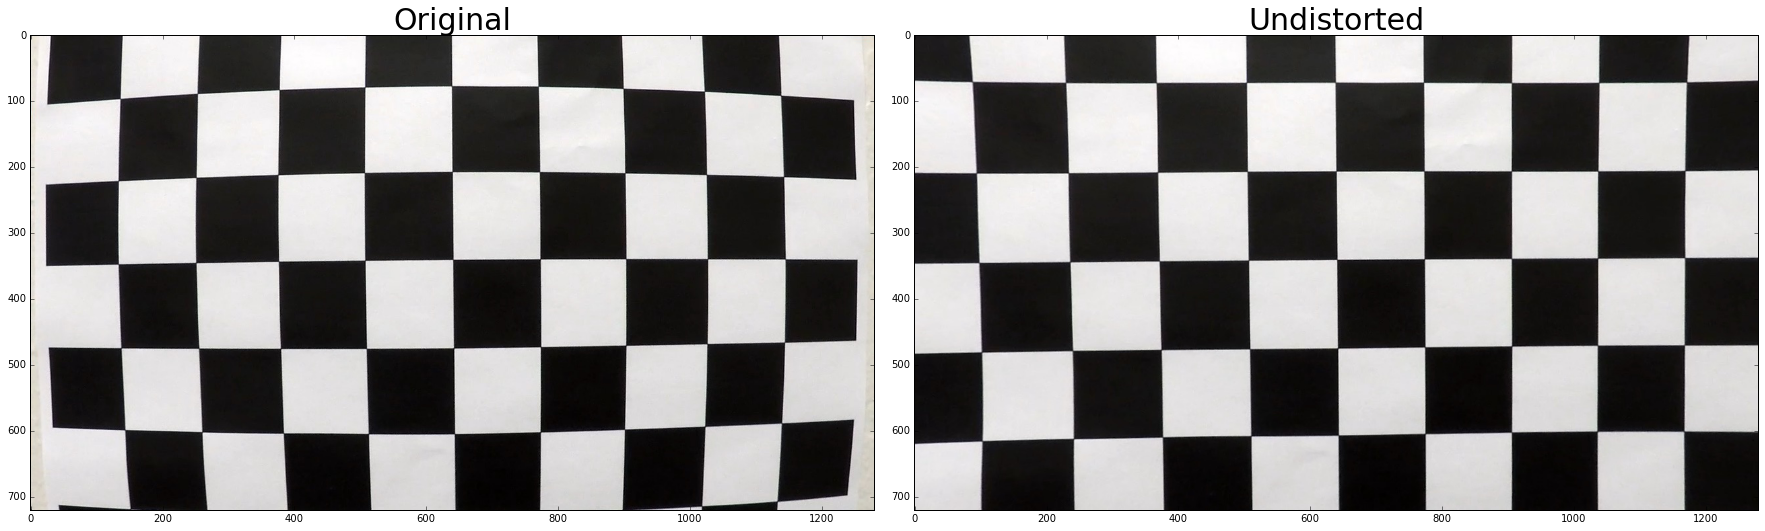

In [26]:
checkerboard_img = mpimg.imread('./camera_cal/calibration1.jpg')
undistorted = correct_distortion(checkerboard_img, cam_mtx, dist_coeffs)
display_images([checkerboard_img, undistorted], ['Original', 'Undistorted'])

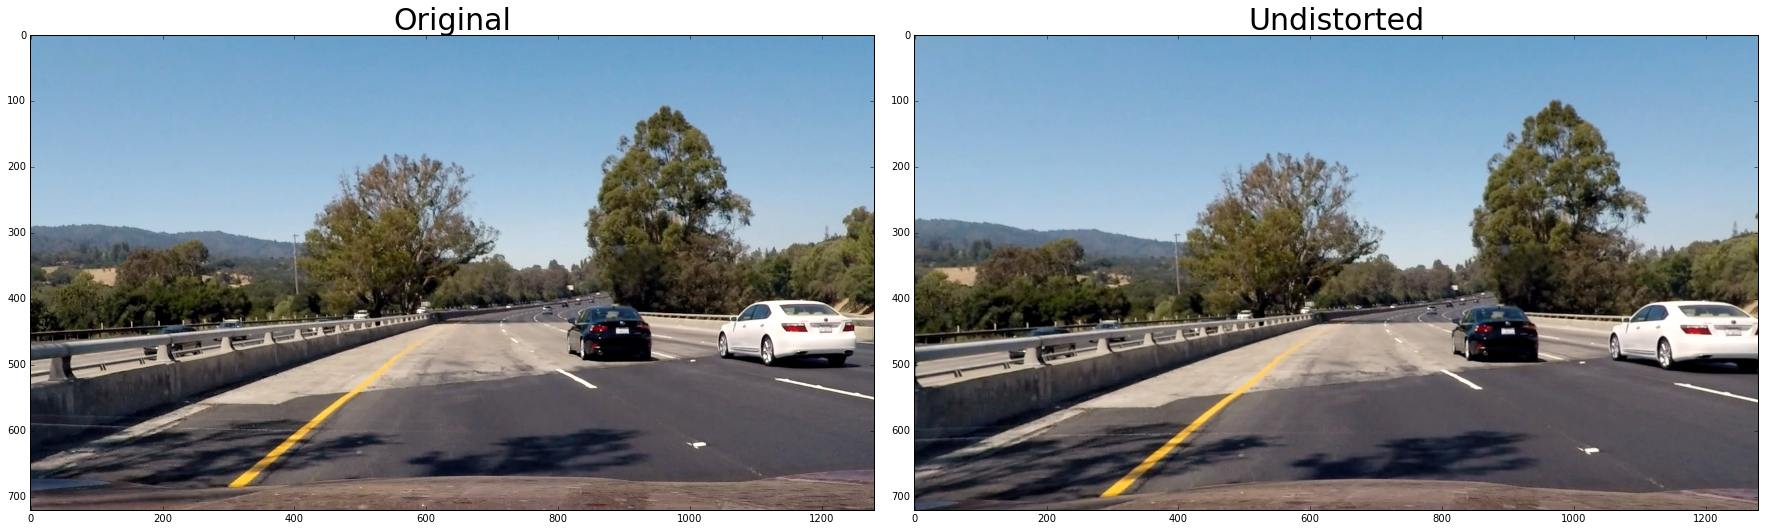

In [27]:
#test_img = mpimg.imread('./test_images/straight_lines1.jpg')
test_img = mpimg.imread('./test_images/test4.jpg')
#test_img = mpimg.imread('./test_images/light-pavement-skid-marks.jpg')

corrected = correct_distortion(test_img, cam_mtx, dist_coeffs)
display_images([test_img, corrected], ['Original', 'Undistorted'])

### 3. Color/gradient thresholding

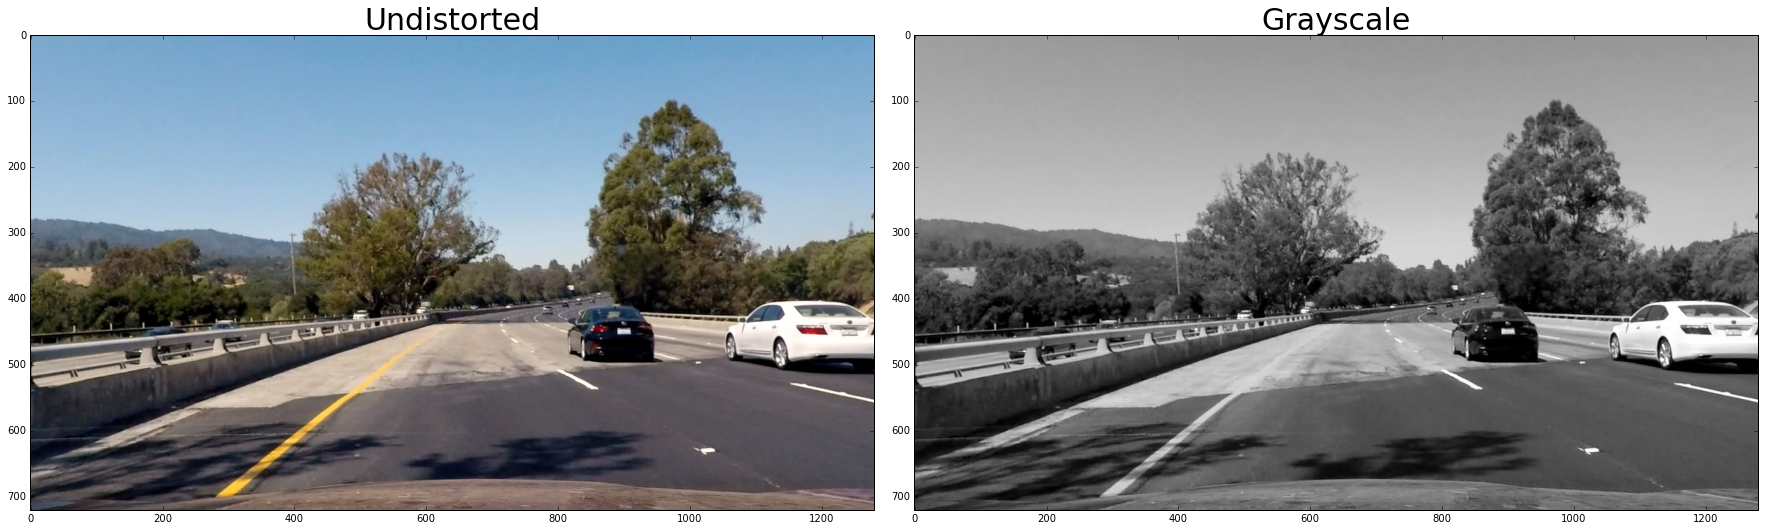

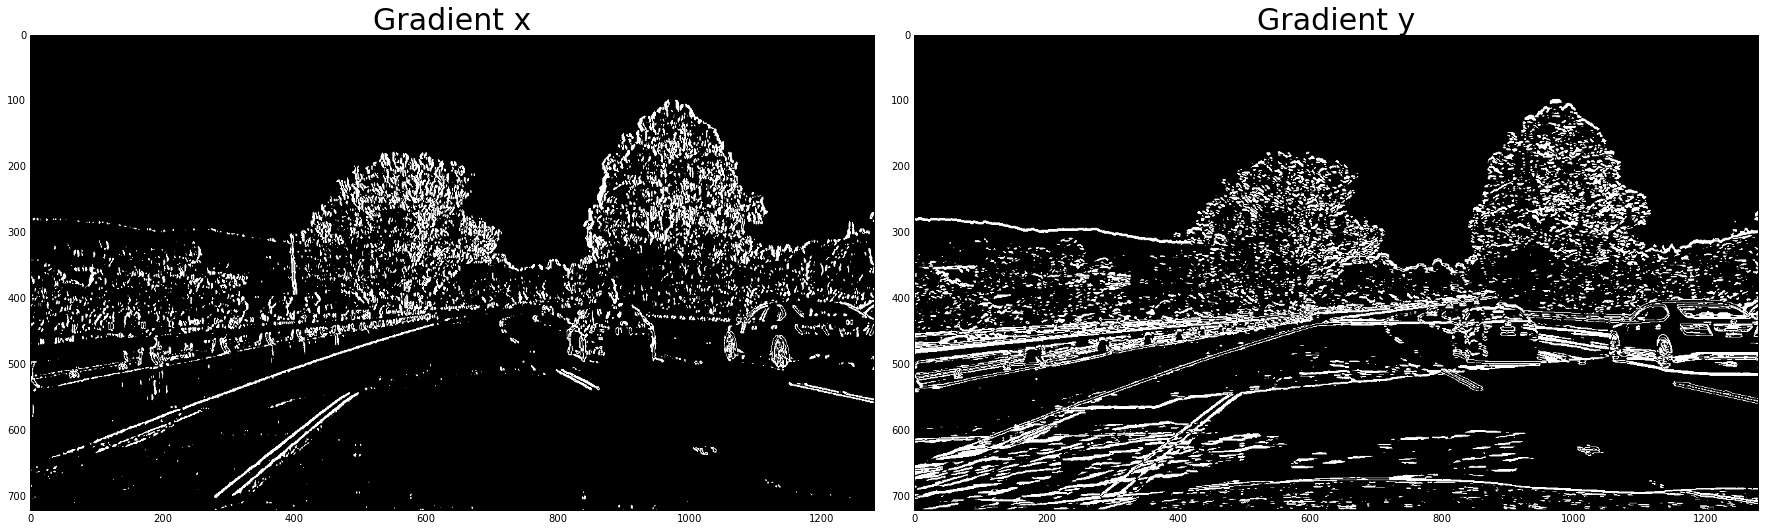

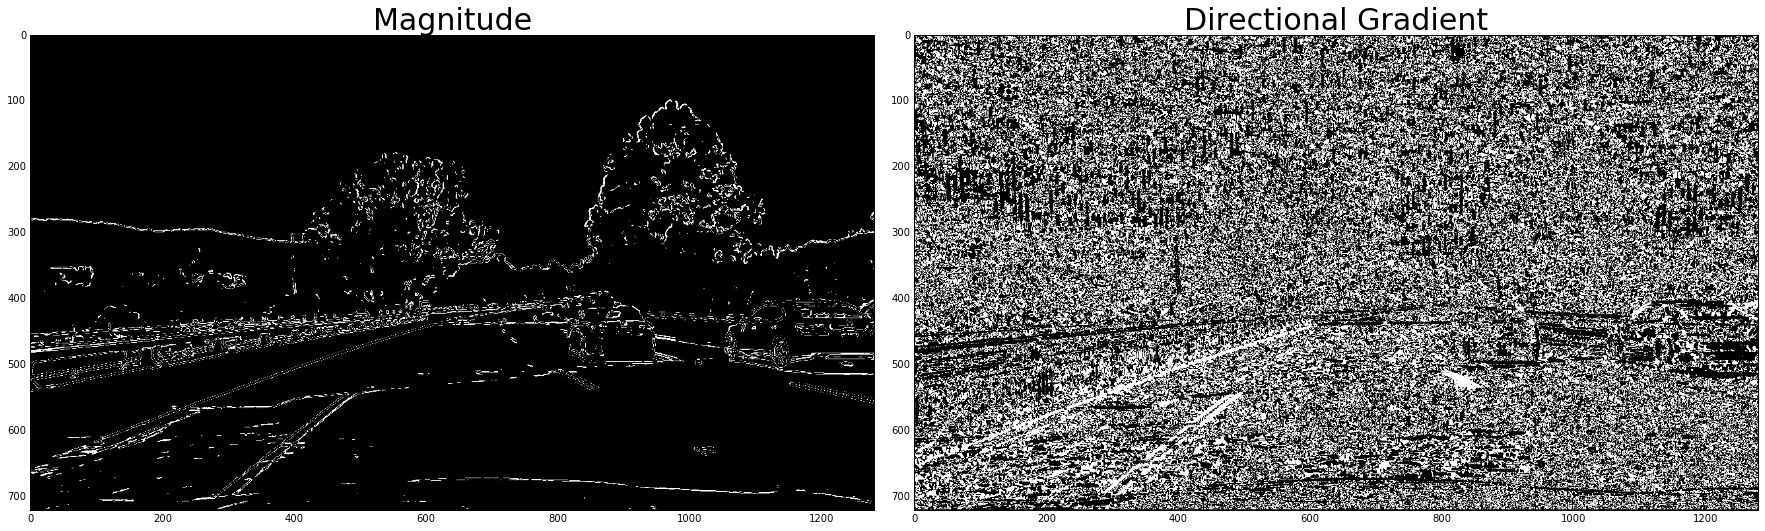

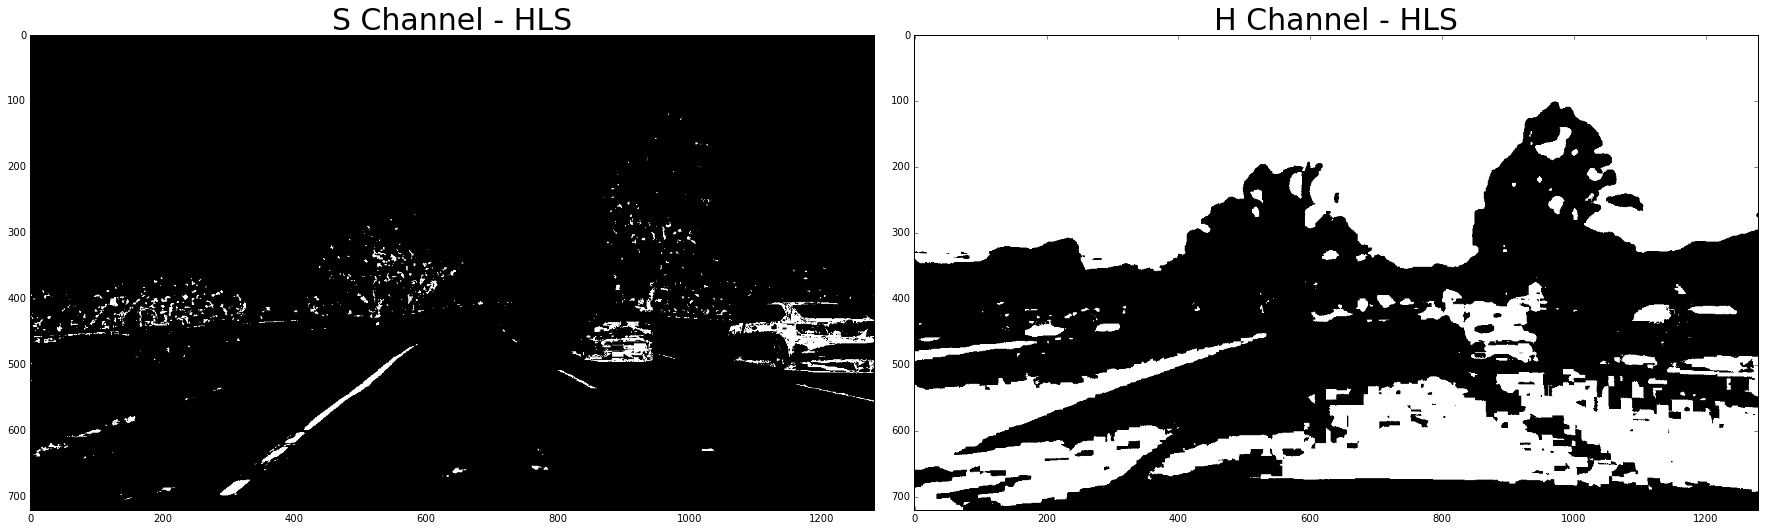

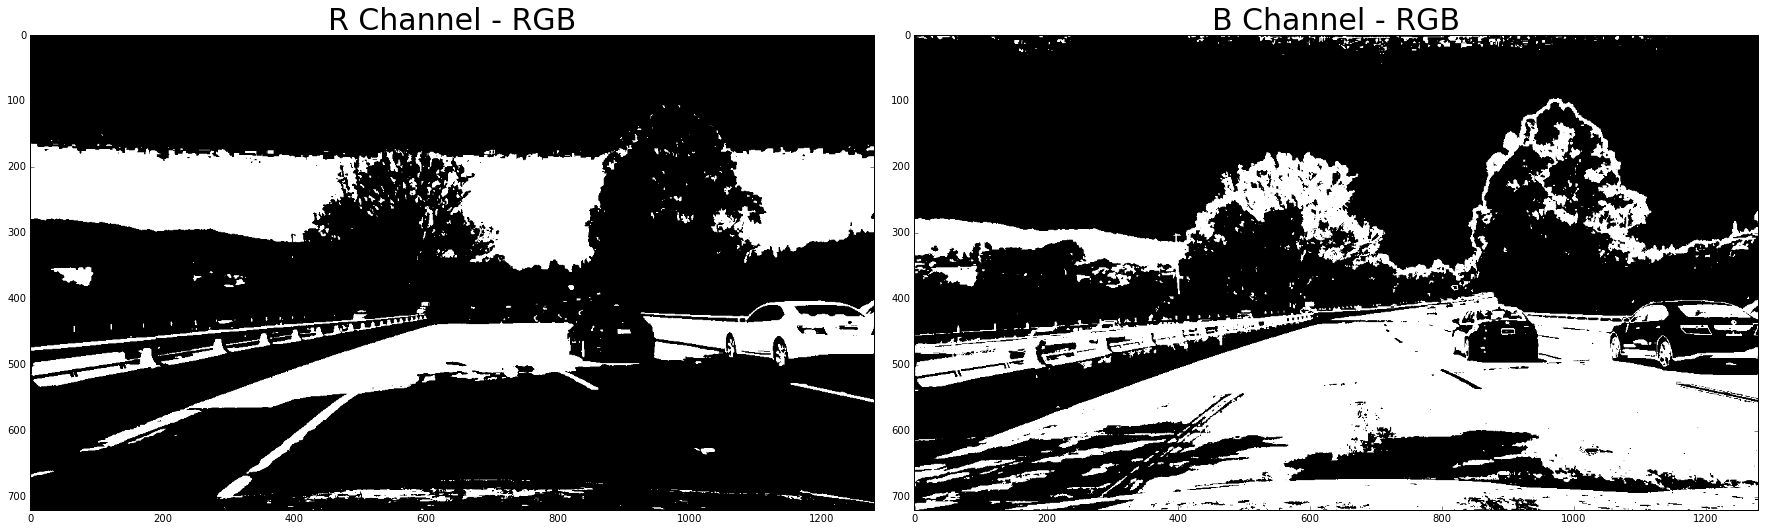

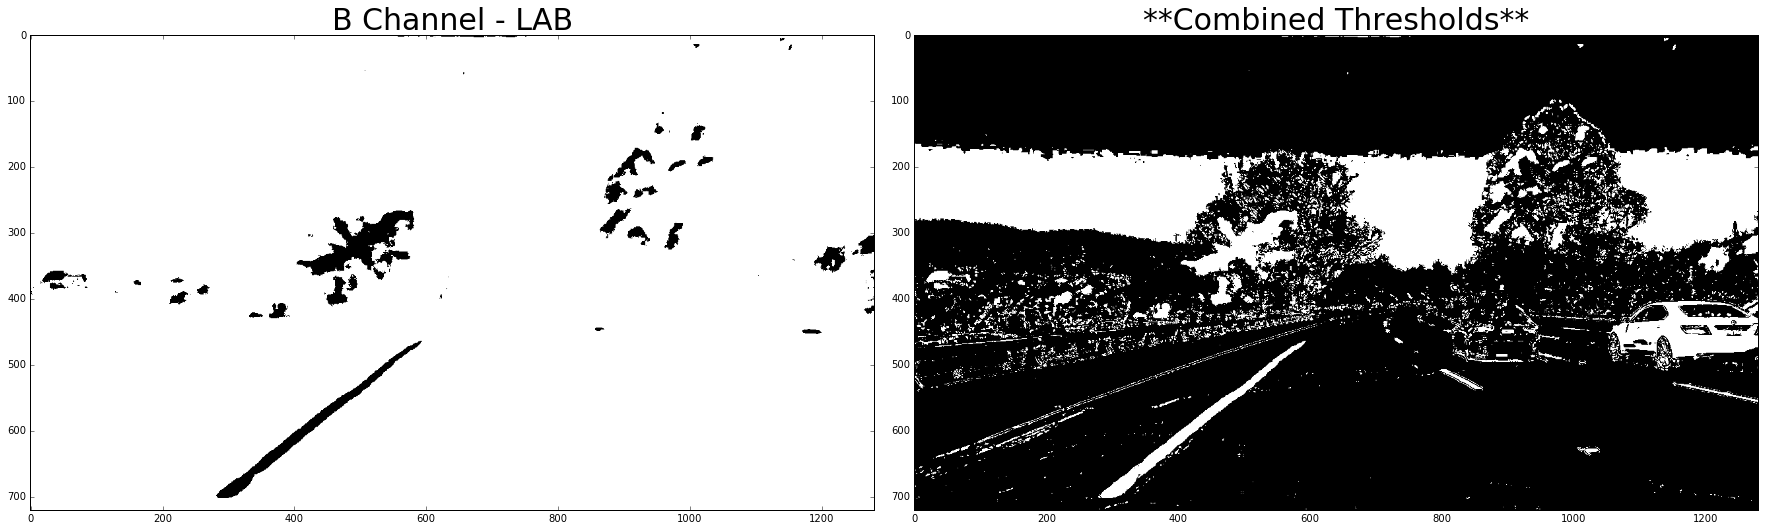

In [28]:
# Test combined threshold
combined_grad_color, gray, gradx, grady, mag_binary, \
dir_binary, s_chan_binary, h_chan_binary, l_chan_binary, \
L_chan_binary, A_chan_binary, B_chan_binary, \
r_chan_binary, g_chan_binary, b_chan_binary = \
    combine_thresholds(corrected)

display_images([corrected, gray], ['Undistorted', 'Grayscale'], ['', 'gray'])
display_images([gradx, grady], ['Gradient x', 'Gradient y'], ['gray', 'gray'])
display_images([mag_binary, dir_binary], ['Magnitude', 'Directional Gradient'], ['gray', 'gray'])
display_images([s_chan_binary, h_chan_binary], ['S Channel - HLS', 'H Channel - HLS'], ['gray', 'gray'])
#display_images([l_chan_binary, r_chan_binary], ['L Channel - HLS', 'R Channel - RGB'], ['gray', 'gray'])
display_images([r_chan_binary, b_chan_binary], ['R Channel - RGB', 'B Channel - RGB'], ['gray', 'gray'])
#display_images([L_chan_binary, A_chan_binary], ['L Channel - LAB', 'A Channel - LAB'], ['gray', 'gray'])
display_images([B_chan_binary, combined_grad_color], ['B Channel - LAB', '**Combined Thresholds**'], ['gray', 'gray'])


### 4. Perspective transform

In [29]:
# Source image vertices for area of interest
stlx =  585
strx =  700
st_y =  455
sblx =  200
sbrx = 1110
sb_y =  720

src = np.float32([[strx, st_y],[sbrx, sb_y],
                  [sblx, sb_y],[stlx, st_y]])

# Destination image vertices for transformed area of interest
dtlx =  320
dtrx =  960
dt_y =    0
dblx = dtlx
dbrx = dtrx
db_y =  720

dst = np.float32([[dtrx, dt_y],[dbrx, db_y],
                  [dblx, db_y],[dtlx, dt_y]])

# Do perspective transformation to get a "Bird's eye view"
warped_corrected, p_M, p_Minv = warp_img(corrected, src, dst)
warped_combined, persp_M, persp_Minv = warp_img(combined_grad_color, src, dst)

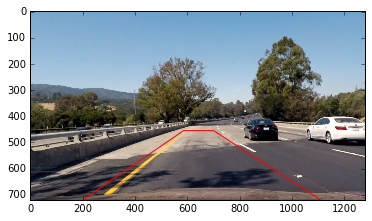

In [30]:
draw_polygon(corrected, src, 'corrected-bounded.png')

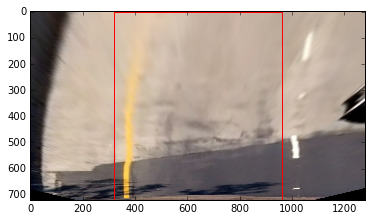

In [31]:
draw_polygon(warped_corrected, dst, 'warped-bounded.png')

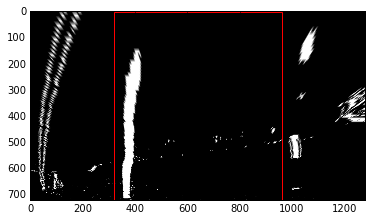

In [32]:
draw_polygon(warped_combined, dst, 'warped_combined-binary-bounded.png')

### 5. Detect lane lines

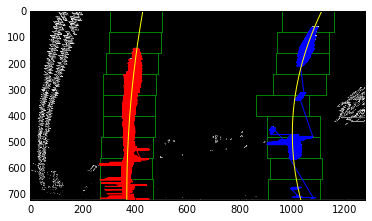

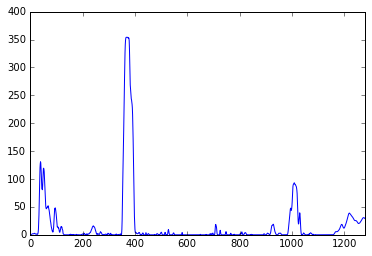

In [33]:
left_fit, right_fit, leftx, lefty, \
rightx, righty, sliding_windows, out_img, \
ploty, left_fitx, right_fitx = \
    detect_lane_lines(warped_combined)
    
visualize_detected_lanes(warped_combined, left_fit, right_fit, leftx, lefty,
                         rightx, righty, sliding_windows, out_img, ploty, left_fitx, right_fitx)

### 6. Determine the lane curvature

In [34]:
y_eval = np.max(ploty)
lane_curve_rads = lane_curvatures(leftx, lefty, rightx, righty, y_eval) 
print(" left curvature: {:.3f} m\nright curvature: {:.3f} m".format(lane_curve_rads[0], lane_curve_rads[1]))

 left curvature: 1308.464 m
right curvature: 322.456 m


### 7. Mark lane detected in image

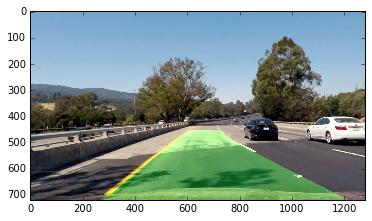

In [35]:
result = draw_lane(test_img, warped_combined, corrected, persp_Minv, ploty, left_fitx, right_fitx)
plt.imshow(result)
plt.savefig('./output_images/lane_marked.png')

------

### Test the pipeline

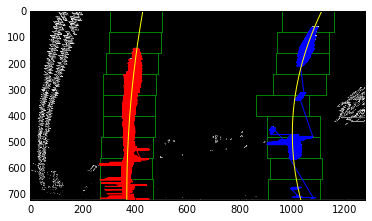

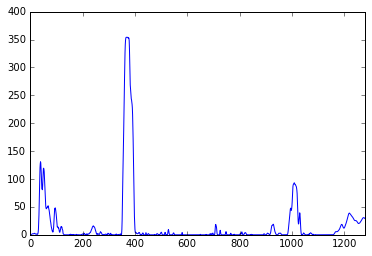

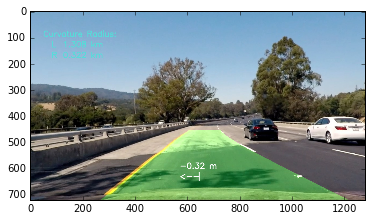

In [38]:
#test_img = mpimg.imread('./test_images/straight_lines1.jpg')
test_img = mpimg.imread('./test_images/test4.jpg')
#test_img = mpimg.imread('./test_images/light-pavement.jpg')
#test_img = mpimg.imread('./test_images/light-pavement-skid-marks.jpg')

lane = find_lane(test_img, cam_mtx, dist_coeffs, DEBUG=True)
plt.imshow(lane)

### Create process function 
for the VideoFileClip to process the frames in the test video clip

In [39]:
CAM_CALIBRATED = False
obj_pts = []
img_pts = []

def process_image(image):
    global CAM_CALIBRATED
    global camera_matrix
    global distortion_coefficients
    
    # Do this only once
    if not CAM_CALIBRATED:
        imgs = glob.glob('./camera_cal/calibration*.jpg')
        camera_matrix, distortion_coefficients = calibrate_camera(imgs)
        CAM_CALIBRATED = True
    
    result = find_lane(image, camera_matrix, distortion_coefficients)
    
    return result


### Process the video clips

In [40]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [41]:
project_output = './output_videos/project_output.mp4'

clip1 = VideoFileClip("./test_videos/project_video.mp4")
proj_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time proj_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video ./output_videos/project_output.mp4
[MoviePy] Writing video ./output_videos/project_output.mp4


100%|█████████▉| 1260/1261 [07:24<00:00,  2.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/project_output.mp4 

CPU times: user 21min 24s, sys: 4.32 s, total: 21min 28s
Wall time: 7min 25s


In [42]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('./output_videos/project_output-v7.mp4'))

In [43]:
challenge_output = './output_videos/challenge_output.mp4'

clip2 = VideoFileClip("./test_videos/challenge_video.mp4")
challenge_clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video ./output_videos/challenge_output.mp4
[MoviePy] Writing video ./output_videos/challenge_output.mp4


100%|██████████| 485/485 [02:44<00:00,  2.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/challenge_output.mp4 

CPU times: user 8min 9s, sys: 1.69 s, total: 8min 11s
Wall time: 2min 45s


In [44]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('./output_videos/challenge_output.mp4'))